# 1.6. Nearest Neighbors
http://scikit-learn.org/stable/modules/neighbors.html

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


sklearn.neighbors provides functionality for unsupervised and supervised neighbors-based learning methods. Unsupervised nearest neighbors is the foundation of many other learning methods, notably manifold learning and spectral clustering. Supervised neighbors-based learning comes in two flavors: classification for data with discrete labels, and regression for data with continuous labels.

The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of samples can be a user-defined constant (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning). The distance can, in general, be any metric measure: standard Euclidean distance is the most common choice. Neighbors-based methods are known as **non-generalizing** machine learning methods, since they simply “remember” all of its training data (possibly transformed into a fast indexing structure such as a Ball Tree or KD Tree.).

Despite its simplicity, nearest neighbors has been successful in a large number of classification and regression problems, including handwritten digits or satellite image scenes. Being a **non-parametric** method, it is often successful in classification situations where the decision boundary is very irregular.

The classes in sklearn.neighbors can handle either Numpy arrays or scipy.sparse matrices as input. For dense matrices, a large number of possible distance metrics are supported. For sparse matrices, arbitrary Minkowski metrics are supported for searches.

There are many learning routines which rely on nearest neighbors at their core. One example is kernel density estimation, discussed in the density estimation section.

## 1.6.1. Unsupervised Nearest Neighbors
NearestNeighbors implements unsupervised nearest neighbors learning. It acts as a uniform interface to three different nearest neighbors algorithms: BallTree, KDTree, and a brute-force algorithm based on routines in sklearn.metrics.pairwise. The choice of neighbors search algorithm is controlled through the keyword `'algorithm'`, which must be one of `['auto', 'ball_tree', 'kd_tree', 'brute']`. When the default value `'auto'` is passed, the algorithm attempts to determine the best approach from the training data. For a discussion of the strengths and weaknesses of each option, see Nearest Neighbor Algorithms.

**Warning** Regarding the Nearest Neighbors algorithms, if two neighbors, neighbor `k+1` and `k`, have identical distances but different labels, the results will depend on the ordering of the training data.

### 1.6.1.1. Finding the Nearest Neighbors
For the simple task of finding the nearest neighbors between two sets of data, the unsupervised algorithms within sklearn.neighbors can be used:

In [8]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
indices

array([[0, 1],
       [1, 0],
       [2, 1],
       [3, 4],
       [4, 3],
       [5, 4]], dtype=int64)

In [3]:
distances

array([[ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.41421356],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.41421356]])

Because the query set matches the training set, the nearest neighbor of each point is the point itself, at a distance of zero.

It is also possible to efficiently produce a sparse graph showing the **connections between neighboring points**:

In [4]:
nbrs.kneighbors_graph(X).toarray()

array([[ 1.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  1.]])

Our dataset is structured such that points nearby in index order are nearby in parameter space, leading to an approximately block-diagonal matrix of K-nearest neighbors. Such a sparse graph is useful in a variety of circumstances which make use of spatial relationships between points for unsupervised learning: in particular, see sklearn.manifold.Isomap, sklearn.manifold.LocallyLinearEmbedding, and sklearn.cluster.SpectralClustering.

### 1.6.1.2. KDTree and BallTree Classes
Alternatively, one can use the KDTree or BallTree classes directly to find nearest neighbors. This is the functionality wrapped by the NearestNeighbors class used above. The Ball Tree and KD Tree have the same interface; we’ll show an example of using the KD Tree here:

In [5]:
from sklearn.neighbors import KDTree
import numpy as np

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
kdt = KDTree(X, leaf_size=30, metric='euclidean')
kdt.query(X, k=2, return_distance=False)    

array([[0, 1],
       [1, 0],
       [2, 1],
       [3, 4],
       [4, 3],
       [5, 4]], dtype=int64)

Refer to the **KDTree** and **BallTree** class documentation for more information on the options available for neighbors searches, including specification of query strategies, of various distance metrics, etc. For a list of available metrics, see the documentation of the DistanceMetric class.

## 1.6.2. Nearest Neighbors Classification
Neighbors-based classification is a type of **instance-based learning** or **non-generalizing learning**: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

scikit-learn implements two different nearest neighbors classifiers: **KNeighborsClassifier** implements learning based on the k nearest neighbors of each query point, where k is an integer value specified by the user. **RadiusNeighborsClassifier** implements learning based on the number of neighbors within a fixed radius r of each training point, where r is a floating-point value specified by the user.

The k-neighbors classification in KNeighborsClassifier is the more commonly used of the two techniques. ***The optimal choice of the value k is highly data-dependent***: in general a larger k suppresses the effects of noise, but makes the classification boundaries less distinct.

In cases where the data is not uniformly sampled, radius-based neighbors classification in RadiusNeighborsClassifier can be a better choice. The user specifies a fixed radius r, such that points in sparser neighborhoods use fewer nearest neighbors for the classification. For high-dimensional parameter spaces, this method becomes less effective due to the so-called **“curse of dimensionality”**.

The basic nearest neighbors classification uses `uniform weights`: that is, the value assigned to a query point is computed from a simple majority vote of the nearest neighbors. Under some circumstances, it is better to weight the neighbors such that nearer neighbors contribute more to the fit. This can be accomplished through the `weights` keyword. The default value, `weights = 'uniform'`, assigns uniform weights to each neighbor. `weights = 'distance'` assigns weights proportional to the inverse of the distance from the query point. Alternatively, a user-defined function of the distance can be supplied which is used to compute the weights.

### Nearest Neighbors Classification
Sample usage of Nearest Neighbors classification. It will plot the decision boundaries for each class.

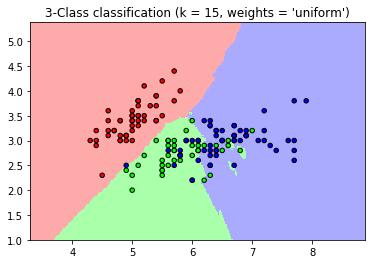

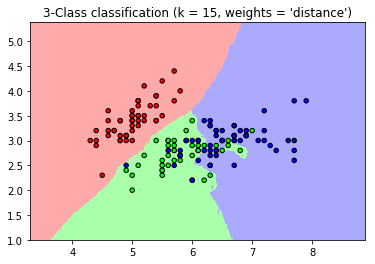

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors,
                                         weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

## 1.6.3. Nearest Neighbors Regression
Neighbors-based regression can be used in cases where the data labels are continuous rather than discrete variables. The label assigned to a query point is computed based the mean of the labels of its nearest neighbors.

scikit-learn implements two different neighbors regressors: `KNeighborsRegressor` implements learning based on the k nearest neighbors of each query point, where k is an integer value specified by the user. `RadiusNeighborsRegressor` implements learning based on the neighbors within a fixed radius r of the query point, where r is a floating-point value specified by the user.

The basic nearest neighbors regression uses `uniform weights`: that is, each point in the local neighborhood contributes uniformly to the classification of a query point. Under some circumstances, it can be advantageous to weight points such that nearby points contribute more to the regression than faraway points. This can be accomplished through the `weights` keyword. The default value, `weights = 'uniform'`, assigns equal weights to all points. `weights = 'distance'` assigns weights proportional to the inverse of the distance from the query point. Alternatively, a user-defined function of the distance can be supplied, which will be used to compute the weights.

### Nearest Neighbors regression¶
Demonstrate the resolution of a regression problem using a k-Nearest Neighbor and the interpolation of the target using both barycenter and constant weights.

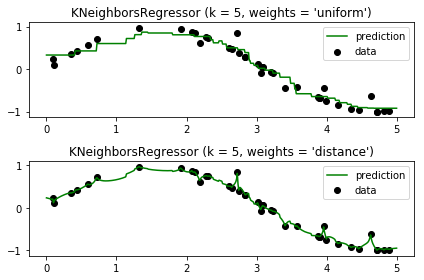

In [42]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Fabian Pedregosa <fabian.pedregosa@inria.fr>
#
# License: BSD 3 clause (C) INRIA


# #############################################################################
# Generate sample data
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors

np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
T = np.linspace(0, 5, 500)[:, np.newaxis]
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))

# #############################################################################
# Fit regression model
n_neighbors = 5

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors,
                                        weights=weights)
    y_ = knn.fit(X, y).predict(T)

    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, c='k', label='data')
    plt.plot(T, y_, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.tight_layout()
plt.show()

The use of multi-output nearest neighbors for regression is demonstrated in Face completion with a multi-output estimators. In this example, the inputs X are the pixels of the upper half of faces and the outputs Y are the pixels of the lower half of those faces.

### Face completion with a multi-output estimators
This example shows the use of multi-output estimator to complete images. The goal is to predict the lower half of a face given its upper half.

The first column of images shows true faces. The next columns illustrate how extremely randomized trees, k nearest neighbors, linear regression and ridge regression complete the lower half of those faces.

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\Wei\scikit_learn_data


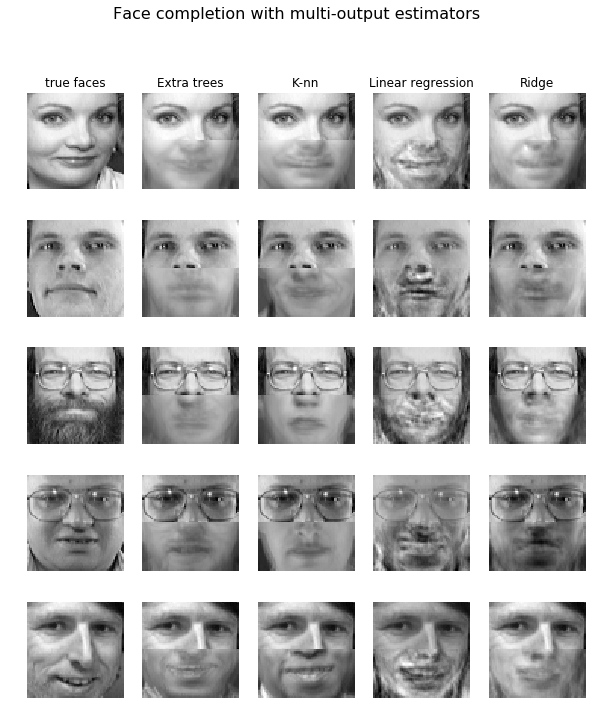

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.validation import check_random_state

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

# Load the faces datasets
data = fetch_olivetti_faces()
targets = data.target

data = data.images.reshape((len(data.images), -1))
train = data[targets < 30]
test = data[targets >= 30]  # Test on independent people

# Test on a subset of people
n_faces = 5
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces, ))
test = test[face_ids, :]

n_pixels = data.shape[1]
# Upper half of the faces
X_train = train[:, :(n_pixels + 1) // 2]
# Lower half of the faces
y_train = train[:, n_pixels // 2:]
X_test = test[:, :(n_pixels + 1) // 2]
y_test = test[:, n_pixels // 2:]

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(n_estimators=10, max_features=32,
                                       random_state=0),
    "K-nn": KNeighborsRegressor(),
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
}

y_test_predict = dict()

for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)  # 使用上半張臉 預測下半張臉
    y_test_predict[name] = estimator.predict(X_test)

# Plot the completed faces
image_shape = (64, 64)

n_cols = 1 + len(ESTIMATORS)
plt.figure(figsize=(2. * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with multi-output estimators", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1,
                          title="true faces")

    sub.axis("off")
    sub.imshow(true_face.reshape(image_shape),
               cmap=plt.cm.gray,
               interpolation="nearest")

    for j, est in enumerate(sorted(ESTIMATORS)):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j,
                              title=est)

        sub.axis("off")
        sub.imshow(completed_face.reshape(image_shape),
                   cmap=plt.cm.gray,
                   interpolation="nearest")

plt.show()

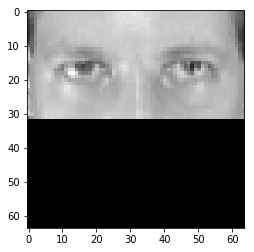

In [40]:
i = 2
completed_face = np.hstack((X_train[i], np.zeros_like(y_train[i])))
plt.imshow(completed_face.reshape(image_shape),
           cmap=plt.cm.gray,
           interpolation="nearest");

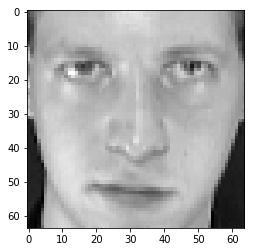

In [41]:
completed_face = np.hstack((X_train[i], y_train[i]))
plt.imshow(completed_face.reshape(image_shape),
           cmap=plt.cm.gray,
           interpolation="nearest");

In [29]:
X_train.shape

(300, 2048)

In [30]:
y_train.shape

(300, 2048)

In [32]:
image_shape

(64, 64)

## 1.6.4. Nearest Neighbor Algorithms¶
### 1.6.4.1. Brute Force
Fast computation of nearest neighbors is an active area of research in machine learning. The most naive neighbor search implementation involves the brute-force computation of distances between all pairs of points in the dataset: for N samples in D dimensions, this approach scales as O[D N^2]. Efficient brute-force neighbors searches can be very competitive for small data samples. However, as the number of samples N grows, the brute-force approach quickly becomes infeasible. In the classes within sklearn.neighbors, brute-force neighbors searches are specified using the keyword `algorithm = 'brute'`, and are computed using the routines available in sklearn.metrics.pairwise.

### 1.6.4.2. K-D Tree
To address the computational inefficiencies of the brute-force approach, a variety of tree-based data structures have been invented. In general, these structures attempt to reduce the required number of distance calculations by efficiently encoding aggregate distance information for the sample. **The basic idea is that if point A is very distant from point B, and point B is very close to point C, then we know that points A and C are very distant, without having to explicitly calculate their distance.** In this way, the computational cost of a nearest neighbors search can be reduced to $O[D N \log(N)]$ or better. This is a significant improvement over brute-force for large N.

An early approach to taking advantage of this aggregate information was the KD tree data structure (short for K-dimensional tree), which generalizes two-dimensional Quad-trees and 3-dimensional Oct-trees to an arbitrary number of dimensions. The KD tree is a binary tree structure which recursively partitions the parameter space along the data axes, dividing it into nested orthotropic regions into which data points are filed. The construction of a KD tree is very fast: because partitioning is performed only along the data axes, no D-dimensional distances need to be computed. Once constructed, the nearest neighbor of a query point can be determined with only  $O[\log(N)]$ distance computations. Though the KD tree approach is very fast for low-dimensional (D < 20) neighbors searches, it becomes inefficient as D grows very large: this is one manifestation of the so-called `“curse of dimensionality”`. In scikit-learn, KD tree neighbors searches are specified using the keyword `algorithm = 'kd_tree'`, and are computed using the class KDTree.

**References:**
“Multidimensional binary search trees used for associative searching”, Bentley, J.L., Communications of the ACM (1975)  

### 1.6.4.3. Ball Tree
To address the inefficiencies of KD Trees in higher dimensions, the ball tree data structure was developed. Where KD trees partition data along Cartesian axes, ball trees partition data in **a series of nesting hyper-spheres**. This makes tree construction more costly than that of the KD tree, but results in a data structure which can be very efficient on highly-structured data, even in very high dimensions.

A ball tree recursively divides the data into nodes defined by a centroid C and radius r, such that each point in the node lies within the hyper-sphere defined by r and C. The number of candidate points for a neighbor search is reduced through use of the triangle inequality:

$|x+y| \leq |x| + |y|$

With this setup, a single distance calculation between a test point and the centroid is sufficient to determine a lower and upper bound on the distance to all points within the node. Because of the spherical geometry of the ball tree nodes, it can out-perform a KD-tree in high dimensions, though the actual performance is highly dependent on the structure of the training data. In scikit-learn, ball-tree-based neighbors searches are specified using the keyword algorithm = 'ball_tree', and are computed using the class sklearn.neighbors.BallTree. Alternatively, the user can work with the BallTree class directly.

**References:**
“Five balltree construction algorithms”, Omohundro, S.M., International Computer Science Institute Technical Report (1989)  

### 1.6.4.4. Choice of Nearest Neighbors Algorithm
The optimal algorithm for a given dataset is a complicated choice, and depends on a number of factors:

- number of samples N (i.e. n_samples) and dimensionality D (i.e. n_features).

 - Brute force query time grows as $O[D N]$
 - Ball tree query time grows as approximately $O[D \log(N)]$
 - KD tree query time changes with D in a way that is difficult to precisely characterise. For small D (less than 20 or so) the cost is approximately $O[D\log(N)]$, and the KD tree query can be very efficient. For larger D, the cost increases to nearly O[DN], and the overhead due to the tree structure can lead to queries which are slower than brute force.  

For small data sets (N less than 30 or so), $\log(N)$ is comparable to N, and brute force algorithms can be more efficient than a tree-based approach. Both KDTree and BallTree address this through providing a leaf size parameter: this controls the number of samples at which a query switches to brute-force. This allows both algorithms to approach the efficiency of a brute-force computation for small N.

- data structure: intrinsic dimensionality of the data and/or sparsity of the data. Intrinsic dimensionality refers to the dimension d $\le$ D of a manifold on which the data lies, which can be linearly or non-linearly embedded in the parameter space. Sparsity refers to the degree to which the data fills the parameter space (this is to be distinguished from the concept as used in “sparse” matrices. The data matrix may have no zero entries, but the structure can still be “sparse” in this sense). 
 - Brute force query time is unchanged by data structure.
 - Ball tree and KD tree query times can be greatly influenced by data structure. In general, sparser data with a smaller intrinsic dimensionality leads to faster query times. Because the KD tree internal representation is aligned with the parameter axes, it will not generally show as much improvement as ball tree for arbitrarily structured data.  
 
Datasets used in machine learning tend to be very structured, and are very well-suited for tree-based queries.

- number of neighbors k requested for a query point.
 - Brute force query time is largely unaffected by the value of k
 - Ball tree and KD tree query time will become slower as k increases. This is due to two effects: first, a larger k leads to the necessity to search a larger portion of the parameter space. Second, using k > 1 requires internal queueing of results as the tree is traversed.  

As k becomes large compared to N, the ability to prune branches in a tree-based query is reduced. In this situation, Brute force queries can be more efficient.

- number of query points. Both the ball tree and the KD Tree require a construction phase. The cost of this construction becomes negligible when amortized over many queries. If only a small number of queries will be performed, however, the construction can make up a significant fraction of the total cost. If very few query points will be required, brute force is better than a tree-based method.

Currently, `algorithm = 'auto'` selects `'kd_tree'` if $k < N/2$ and the `'effective_metric_'` is in the `'VALID_METRICS'` list of `'kd_tree'`. It selects `'ball_tree'` if $k < N/2$ and the `'effective_metric_'` is in the `'VALID_METRICS'` list of `'ball_tree'`. It selects `'brute'` if $k < N/2$ and the `'effective_metric_'` is not in the `'VALID_METRICS'` list of `'kd_tree'` or `'ball_tree'`. It selects `'brute'` if $k >= N/2$. This choice is based on the assumption that the number of query points is at least the same order as the number of training points, and that leaf_size is close to its default value of 30.

### 1.6.4.5. Effect of leaf_size
As noted above, for small sample sizes a brute force search can be more efficient than a tree-based query. This fact is accounted for in the ball tree and KD tree by internally switching to brute force searches within leaf nodes. The level of this switch can be specified with the parameter `leaf_size`. This parameter choice has many effects:

**construction time**  
A larger leaf_size leads to a faster tree construction time, because fewer nodes need to be created  

**query time**  
Both a large or small leaf_size can lead to suboptimal query cost. For leaf_size approaching 1, the overhead involved in traversing nodes can significantly slow query times. For leaf_size approaching the size of the training set, queries become essentially brute force. A good compromise between these is leaf_size = 30, the default value of the parameter.

**memory**  
As leaf_size increases, the memory required to store a tree structure decreases. This is especially important in the case of ball tree, which stores a D-dimensional centroid for each node. The required storage space for BallTree is approximately `1 / leaf_size` times the size of the training set.  

`leaf_size` is not referenced for brute force queries.

### 1.6.5. Nearest Centroid Classifier
The NearestCentroid classifier is a simple algorithm that represents each class by the centroid of its members. In effect, this makes it similar to **the label updating phase of the sklearn.KMeans algorithm**. It also has no parameters to choose, making it a good baseline classifier. It does, however, suffer on non-convex classes, as well as when classes have drastically different variances, as equal variance in all dimensions is assumed. See Linear Discriminant Analysis (sklearn.discriminant_analysis.LinearDiscriminantAnalysis) and Quadratic Discriminant Analysis (sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis) for more complex methods that do not make this assumption. Usage of the default NearestCentroid is simple:

In [33]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([1, 1, 1, 2, 2, 2])
clf = NearestCentroid()
clf.fit(X, y)

NearestCentroid(metric='euclidean', shrink_threshold=None)

In [34]:
print(clf.predict([[-0.8, -1]]))

[1]


### 1.6.5.1. Nearest Shrunken Centroid
The NearestCentroid classifier has a `shrink_threshold` parameter, which implements the nearest shrunken centroid classifier. In effect, the **value of each feature for each centroid is divided by the within-class variance of that feature**. The feature values are then reduced by shrink_threshold. Most notably, if a particular feature value crosses zero, it is set to zero. In effect, this removes the feature from affecting the classification. This is useful, for example, for removing noisy features.

In the example below, using a small shrink threshold increases the accuracy of the model from 0.81 to 0.82.

### Nearest Centroid Classification¶
Sample usage of Nearest Centroid classification. It will plot the decision boundaries for each class.

None 0.813333333333
0.2 0.82


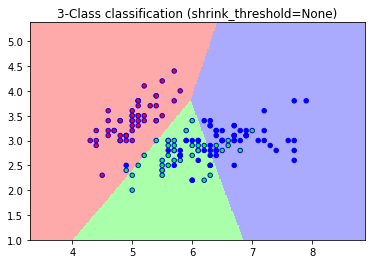

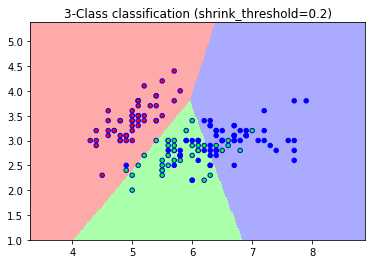

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.neighbors import NearestCentroid

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()
# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for shrinkage in [None, .2]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = NearestCentroid(shrink_threshold=shrinkage)
    clf.fit(X, y)
    
    y_pred = clf.predict(X)
    print(shrinkage, np.mean(y == y_pred))
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='b', s=20)
    plt.title("3-Class classification (shrink_threshold=%r)"
              % shrinkage)
    plt.axis('tight')

plt.show()